In [4]:
'''Example of use, and calculating errors
As a guide to how to successfully read in and interpret this file, we reproduce here code from "read_frame.pro" in the photoop IDL product:

;; 0. find filename of the frame file
framename = (sdss_name('frame', run, camcol, field, $
                       filter=filternum(filter), rerun=rerun))[0]+'.bz2'

;; 1. read in the FITS image from HDU0; the resulting image will be
;;    sky-subtracted as well as calibrated in nanomaggies/pixel
img= mrdfits(framename,0,hdr)
nrowc= (size(img,/dim))[1]

;; 2. read in sky, and interpolate to full image size; this returns a
;;    sky image the same size as the frame image, in units of counts
sky= mrdfits(framename,2)
simg= interpolate(sky.allsky, sky.xinterp, sky.yinterp, /grid)

;; 3. read in calibration, and expand to full image size; this returns
;;    a calibration image the same size as the frame image, in units of
;;    nanomaggies per count
calib= mrdfits(framename,1)
cimg= calib#replicate(1.,nrowc)
Steps (0) and (1) just read in the "image". Step (2) reads in the sky HDU, and bilinearly interpolates "allsky" onto a 2048x1489 sized array at the points on the grid defined by "xinterp" and "yinterp". Step (3) reads in the 2048-element vector defined the calibration-times-flat-field for each row, and expands it to a full-sized image.

If you have performed the above calculations, you can return the image to very close to the state it was in when input into the photometric pipeline, as follows:

dn= img/cimg+simg
These dn values are in the same units as the "data numbers" stored by the raw data files that come off the instrument. They are related to the detected number nelec of photo-electrons by:

nelec= dn*gain
The number of photo-electrons is the quantity that is statistically Poisson distributed. In addition, there are additional sources of noise from the read-noise and the noise in the dark current, which we will lump together here as the "dark variance." Thus, to calculate per-pixel uncertainties, you need the gain and darkVariance for the field in question. The darkVariance comes from the read noise and the noise in the dark current. In fact, these are nearly fixed as a function of camcol and filter (see the table below). You can retrieve the values from the field table in CAS (or the photoField file). With those values in hand the following yields the errors in DN:

dn_err= sqrt(dn/gain+darkVariance)
Statistical errors in the sky values are completely negligible. Finally, to get those errors into nanomaggies, you simply apply back the calibration:

img_err= dn_err*cimg
Finally, there are some areas of the image which are part of bleed trails, bad columns, and the like. If you require to track those in your analysis (e.g. weight them at zero) then you need to use the fpM files. Those files are in a special format, best read using the stand-alone atlas reader software. Use the utility called read_mask.

The gain and dark variance values are given below as a function of camcol and filter. In some cases the configuration was changed during the survey, and those cases are noted below. In detail, some chips had two amplifiers, and in those cases the values below are an intermediate value.'''

'Example of use, and calculating errors\nAs a guide to how to successfully read in and interpret this file, we reproduce here code from "read_frame.pro" in the photoop IDL product:\n\n;; 0. find filename of the frame file\nframename = (sdss_name(\'frame\', run, camcol, field, $\n                       filter=filternum(filter), rerun=rerun))[0]+\'.bz2\'\n\n;; 1. read in the FITS image from HDU0; the resulting image will be\n;;    sky-subtracted as well as calibrated in nanomaggies/pixel\nimg= mrdfits(framename,0,hdr)\nnrowc= (size(img,/dim))[1]\n\n;; 2. read in sky, and interpolate to full image size; this returns a\n;;    sky image the same size as the frame image, in units of counts\nsky= mrdfits(framename,2)\nsimg= interpolate(sky.allsky, sky.xinterp, sky.yinterp, /grid)\n\n;; 3. read in calibration, and expand to full image size; this returns\n;;    a calibration image the same size as the frame image, in units of\n;;    nanomaggies per count\ncalib= mrdfits(framename,1)\ncimg= cali

In [ ]:
'''Where to find the preimage data?'''
#https://data.sdss.org/datamodel/files/MANGAPREIM_DIR/data/DESIGNID6XX/DESIGNID/preimage.html

In [2]:
'''purpose: figure out whats going on with the sdss imaging data'''
'''what is the noise, what is the sky bg'''
import pyfits
import matplotlib.pyplot as plt
import heapq
import pyfits
import matplotlib as plt
from pylab import *
import numpy as np
from decimal import *
import numpy
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy.modeling import models, fitting
from pylab import *
from scipy import stats
from scipy.stats import chisquare
import matplotlib.patches as patches
from astropy.io import fits
from scipy import interpolate

frames/frame-r-001365-1-0034.fits
0.00494812 calibration factor nmgy/count


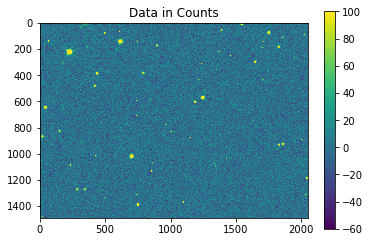

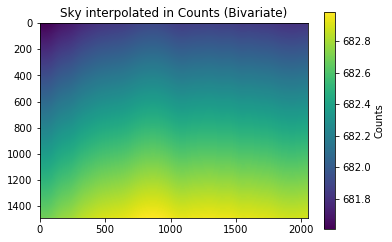

frames/frame-r-001365-2-0093.fits
0.00512121 calibration factor nmgy/count


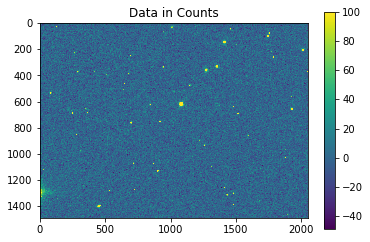

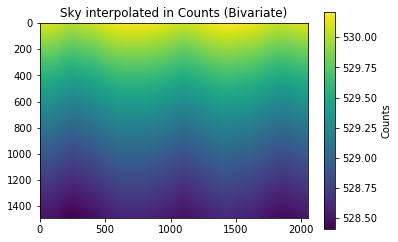

frames/frame-r-001365-3-0044.fits
0.00478119 calibration factor nmgy/count


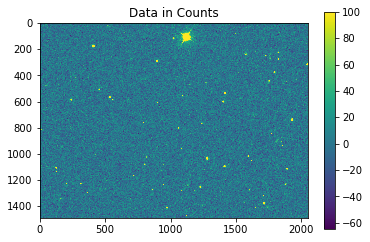

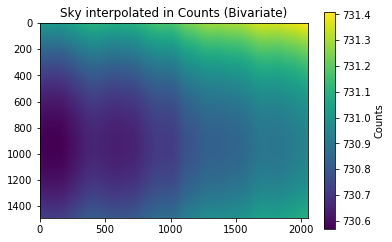

frames/frame-r-001365-4-0025.fits
0.00488696 calibration factor nmgy/count


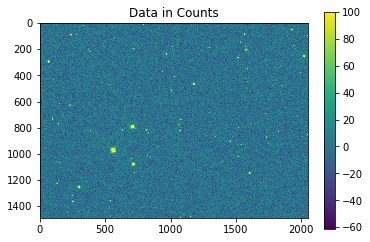

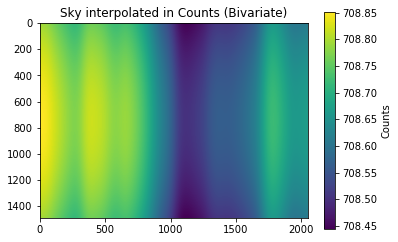

frames/frame-r-001365-5-0108.fits
0.00507473 calibration factor nmgy/count


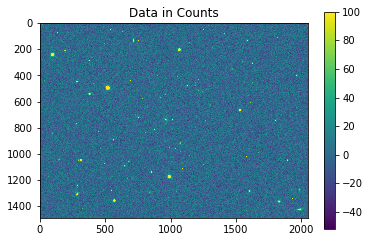

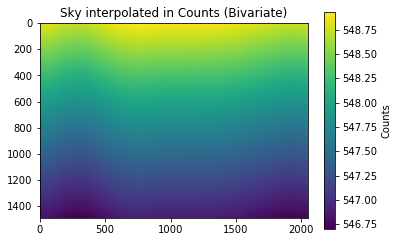

frames/frame-r-001365-6-0127.fits
0.005153 calibration factor nmgy/count


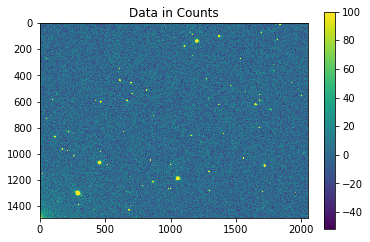

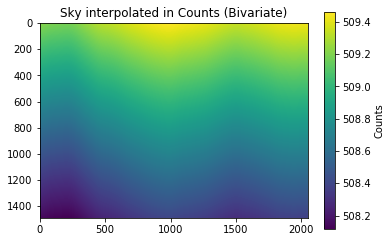

frames/frame-r-001862-5-0064.fits
0.00474783 calibration factor nmgy/count


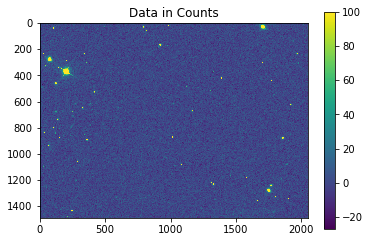

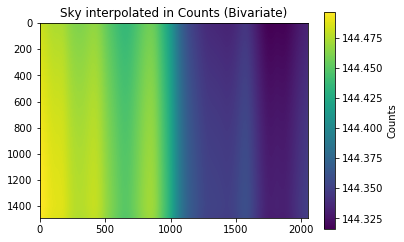

frames/frame-r-003918-3-0213.fits
0.00511409 calibration factor nmgy/count


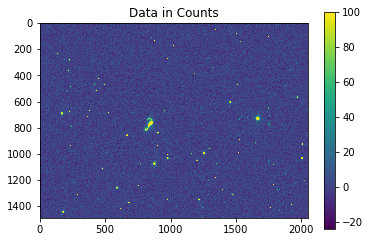

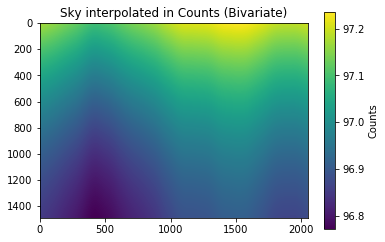

c_factor 0.00497839125 [0.00494812, 0.00512121, 0.00478119, 0.00488696, 0.00507473, 0.005153, 0.00474783, 0.00511409]
sky_factor 493.637910493 [682.38785310540322, 529.22480206815601, 730.86436324248007, 708.66337676239107, 547.76635930313716, 508.80936872326583, 144.40517057708396, 96.981990164276183]


In [143]:
'''Actually lets use the frames datamodel'''

im=pyfits.open('frames/frame-r-001365-1-0034.fits')
#run for a variety of camcols
#also try different tiles?
datas=['frames/frame-r-001365-1-0034.fits','frames/frame-r-001365-2-0093.fits',
      'frames/frame-r-001365-3-0044.fits','frames/frame-r-001365-4-0025.fits',
      'frames/frame-r-001365-5-0108.fits','frames/frame-r-001365-6-0127.fits',
      'frames/frame-r-001862-5-0064.fits','frames/frame-r-003918-3-0213.fits']
#where to get the frames --> https://dr13.sdss.org/sas/dr13/eboss/photoObj/frames/301/1365/2/
sky_factor=[]
c_factor=[]
for i in range(len(datas)):
    print(datas[i])
    im=pyfits.open(datas[i])
    sky=im[2].data

    sky_header=im[2].header



    calib=im[1].data


    


    import itertools

    xs=np.linspace(0,255,256)
    ys=np.linspace(0,191,192)


    snew=RectBivariateSpline(ys,xs,sky[0][0])(sky[0][2],sky[0][1],grid=True)



    print(im[0].header['NMGY'], 'calibration factor nmgy/count')
    
    
    '''plt.imshow(sky[0][0])
    plt.title('Sky pre-interpolation in Counts')
    plt.colorbar()
    plt.show()

    plt.imshow(im[0].data, vmin=0, vmax=.2)
    plt.title('Data in Nanomaggies')
    plt.colorbar()
    plt.show()'''
    
    plt.imshow(im[0].data/im[0].header['NMGY'], vmax=100)
    plt.title('Data in Counts')
    plt.colorbar()
    plt.show()

    plt.imshow(snew)
    plt.title('Sky interpolated in Counts (Bivariate)')
    plt.colorbar(label='Counts')
    plt.show()
    
    c_factor.append(im[0].header['NMGY'])
    sky_factor.append(np.mean(snew))
print('c_factor', np.mean(c_factor),c_factor)
print('sky_factor', np.mean(sky_factor),sky_factor)

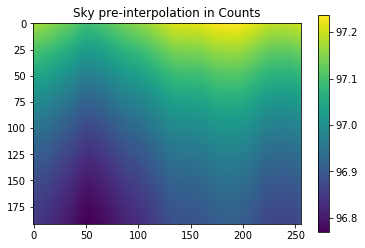

0.00511409 calibration factor nmgy/count
SIMPLE  =                    T /                                                BITPIX  =                  -32 / 32 bit floating point                          NAXIS   =                    2                                                  NAXIS1  =                 2048                                                  NAXIS2  =                 1489                                                  EXTEND  =                    T /Extensions may be present                       BZERO   =              0.00000 /Set by MRD_SCALE                                BSCALE  =              1.00000 /Set by MRD_SCALE                                TAI     =        4558308519.70 / 1st row - Number of seconds since Nov 17 1858  RA      =            228.96714 / 1st row - Right ascension of telescope boresighDEC     =            43.167056 / 1st row - Declination of telescope boresight (dSPA     =             123.421  / 1st row - Camera col position angle wrt north 

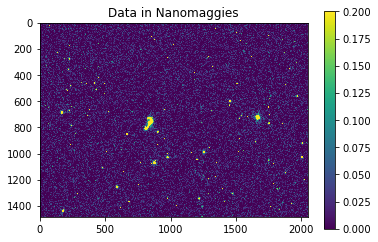

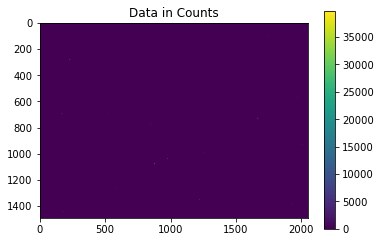

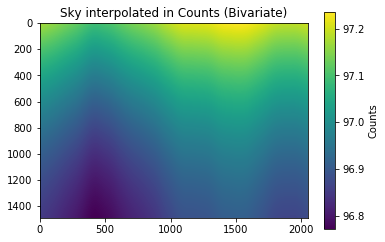

In [140]:
im=pyfits.open('frames/frame-r-003918-3-0213.fits')
#where to get the frames --> https://dr13.sdss.org/sas/dr13/eboss/photoObj/frames/301/1365/2/


sky=im[2].data

sky_header=im[2].header



calib=im[1].data


plt.imshow(sky[0][0])
plt.title('Sky pre-interpolation in Counts')
plt.colorbar()
plt.show()


import itertools

xs=np.linspace(0,255,256)
ys=np.linspace(0,191,192)


snew=RectBivariateSpline(ys,xs,sky[0][0])(sky[0][2],sky[0][1],grid=True)



print(im[0].header['NMGY'], 'calibration factor nmgy/count')
print(im[0].header)

plt.imshow(im[0].data, vmin=0, vmax=.2)
plt.title('Data in Nanomaggies')
plt.colorbar()
plt.show()

plt.imshow(im[0].data/im[0].header['NMGY'])
plt.title('Data in Counts')
plt.colorbar()
plt.show()

plt.imshow(snew)
plt.title('Sky interpolated in Counts (Bivariate)')
plt.colorbar(label='Counts')
plt.show()



[[ 0.00516532  0.00516456  0.00516377 ...,  0.00514269  0.00514084
   0.00514153]]
(1, 2048)
0.00512684 5.16904e-06
(3049472,)


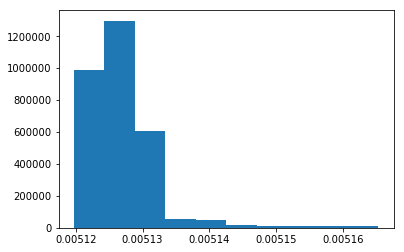

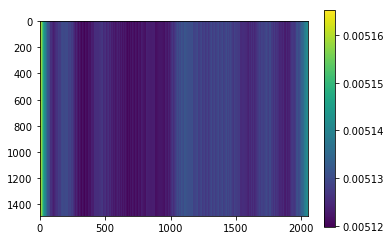

(1489, 2048)


In [123]:
print(np.array([im[1].data,]))

print(shape(np.array([im[1].data,])))

calibration=np.repeat(np.array([im[1].data,]), 1489,axis=0)

print(np.mean(calibration), np.std(calibration))
print(shape(calibration.ravel()))

plt.hist(calibration.ravel())
plt.show()

plt.imshow(calibration)
plt.colorbar()
plt.show()

print(shape(calibration))

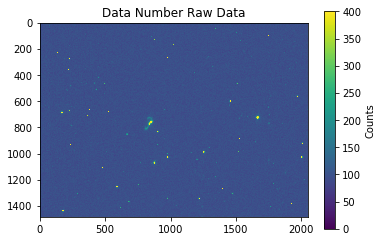

Mean DN for a background patch in counts (should be close to 97) 97.0000131882


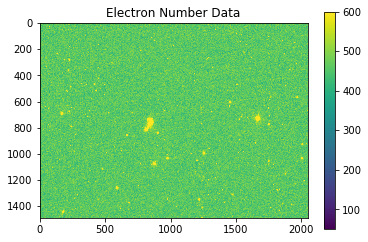

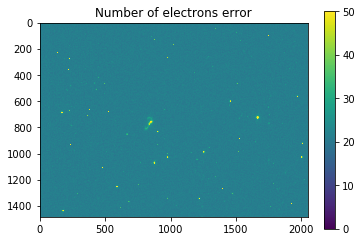

this is how you can do poisson noise


/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:58: RuntimeWarning: divide by zero encountered in true_divide


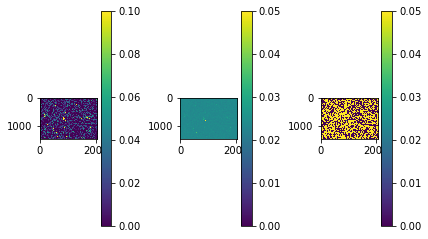

In [120]:
#
plt.clf()

img=im[0].data
cimg=calibration
simg=snew
dn= img/cimg+simg#in counts

plt.imshow(dn, vmin=0, vmax=400)
plt.title('Data Number Raw Data')
plt.colorbar(label='Counts')
plt.show()

print('Mean DN for a background patch in counts (should be close to 97)', np.median(dn))
#These dn values are in the same units as the "data numbers" stored by the raw data files that come off the instrument. They are related to the detected number nelec of photo-electrons by:

gain=4.735#mean for all camcols for r band filter

nelec= dn*gain


plt.imshow(nelec, vmin=50,vmax=600)
plt.title('Electron Number Data')
plt.colorbar()
plt.show()

plt.imshow(np.sqrt(nelec), vmin=0,vmax=50)
plt.title('Number of electrons error')
plt.colorbar()
plt.show()

print('this is how you can do poisson noise')


#dark variance is very very small :1.3225
# = read noise and dark current

darkVariance=1.19666666

dn_err= np.sqrt(dn/gain+darkVariance)

img_err= dn_err*cimg
plt.clf()



fig=plt.figure()
ax1=fig.add_subplot(1,3,1)
im1=ax1.imshow(img, vmin=0, vmax=0.1)
plt.colorbar(im1)


ax2=fig.add_subplot(1,3,2)
im2=ax2.imshow(img_err ,vmin=0, vmax=0.05)
plt.colorbar(im2)

ax3=fig.add_subplot(1,3,3)
im3=ax3.imshow(img_err/img ,vmin=0, vmax=0.05)
plt.colorbar(im3)

plt.tight_layout()
plt.show()
#savefig('percent_error_sdss.pdf')




/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


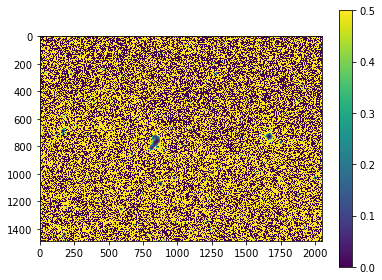

In [11]:
plt.clf()
plt.imshow(img_err/img, vmin=0,vmax=0.5)
plt.colorbar()
plt.show()


In [10]:
x = np.array([[1,2],])
print(x)
np.repeat(x, 3, axis=0)

[[1 2]]


array([[1, 2],
       [1, 2],
       [1, 2]])

In [188]:
'''Comparing for a preimage image'''

'''From:
     https://svn.sdss.org/public/data/manga/mangapreim/tags/v2_1'''

filenames=['preimage-1-32048.fits','preimage-1-107659.fits','preimage-1-548200.fits',
           'preimage-1-351628.fits','preimage-1-351478.fits',
           'preimage-1-486227.fits','preimage-1-488464.fits','preimage-1-135054.fits',
           'preimage-1-211063.fits','preimage-1-594446.fits',
           'preimage-1-255691.fits','preimage-1-137714.fits','preimage-1-217050.fits',
           'preimage-1-277103.fits','preimage-1-558910.fits',
           'preimage-1-202097.fits','preimage-1-22286.fits','preimage-1-229021.fits',
           'preimage-1-38887.fits','preimage-1-594809.fits',
           'preimage-1-635629.fits','preimage-1-180381.fits',
           'preimage-1-180080.fits','preimage-1-177809.fits',
           'preimage-1-379528.fits',
    'preimage-1-247339.fits','preimage-1-31639.fits',
           'preimage-1-32058.fits',
            'preimage-1-542312.fits','preimage-1-92487.fits','preimage-1-93705.fits',
           'preimage-1-177336.fits','preimage-1-177460.fits','preimage-1-177624.fits','preimage-1-177923.fits','preimage-1-634588.fits',
            'preimage-1-177358.fits','preimage-1-177478.fits','preimage-1-177625.fits','preimage-1-178084.fits',
            'preimage-1-177397.fits','preimage-1-177495.fits','preimage-1-177635.fits','preimage-1-211872.fits',
            'preimage-1-177610.fits','preimage-1-177659.fits',
           'preimage-1-338579.fits','preimage-1-43188.fits','preimage-1-561117.fits','preimage-1-208898.fits']

print(len(filenames))

50


skyval 0.0
gain 956.828
skyval 0.0
gain 936.639
skyval 0.0
gain 1498.35
skyval 0.0
gain 978.542
skyval 0.0
gain 1039.02
skyval 0.0
gain 907.509
skyval 0.0
gain 960.274
skyval 0.0
gain 911.044
skyval 0.0
gain 1557.29
skyval 0.0
gain 819.789
skyval 0.0
gain 879.19
skyval 0.0
gain 1679.19
skyval 0.0
gain 1019.65
skyval 0.0
gain 950.012
skyval 0.0
gain 888.419
skyval 0.0
gain 5027.91
skyval 0.0
gain 2028.16
skyval 0.0
gain 1984.24
skyval 0.0
gain 2555.23
skyval 0.0
gain 2006.72
skyval 0.0
gain 1993.89
skyval 0.0
gain 1002.56
skyval 0.0
gain 1773.87
skyval 0.0
gain 971.966
skyval 0.0
gain 1948.55
skyval 0.0
gain 871.004
skyval 0.0
gain 958.288
skyval 0.0
gain 984.402
skyval 0.0
gain 1002.88
skyval 0.0
gain 947.366
skyval 0.0
gain 1016.93
skyval 0.0
gain 1705.8
skyval 0.0
gain 1969.42
skyval 0.0
gain 1625.66
skyval 0.0
gain 940.313
skyval 0.0
gain 1213.33
skyval 0.0
gain 1912.31
skyval 0.0
gain 1787.45
skyval 0.0
gain 972.605
skyval 0.0
gain 940.292
skyval 0.0
gain 912.471
skyval 0.0
gain 10

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:40: RuntimeWarning: invalid value encountered in sqrt
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:107: RuntimeWarning: invalid value encountered in sqrt
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:111: RuntimeWarning: invalid value encountered in sqrt
/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:175: RuntimeWarning: invalid value encountered in sqrt


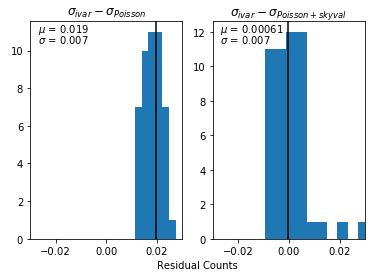

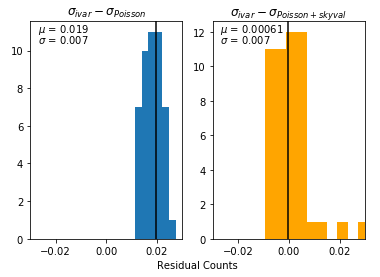

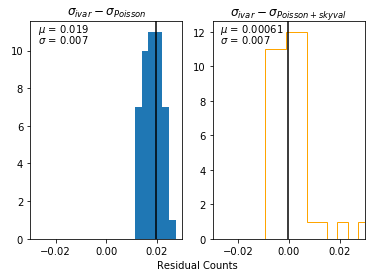

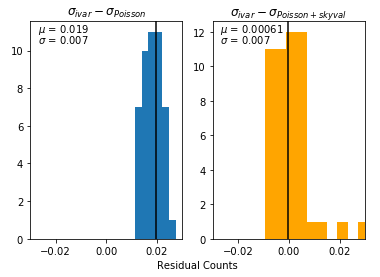

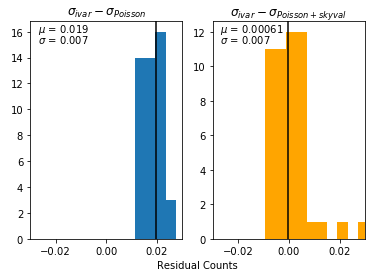

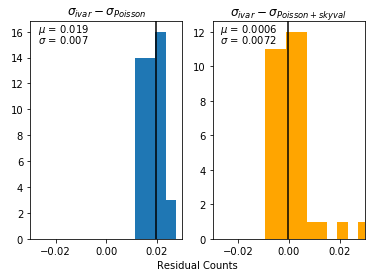

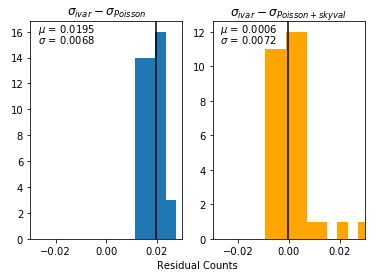

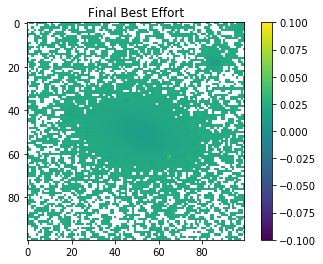

0.0247166304898 0.00135492561624


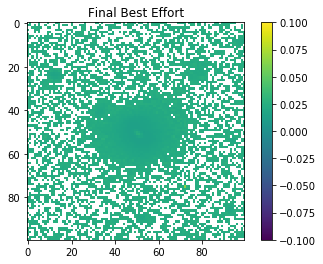

0.0189974649991 0.00105576437991


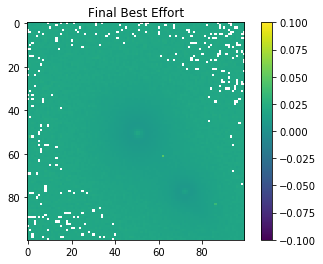

0.0260496651897 0.00115302849715


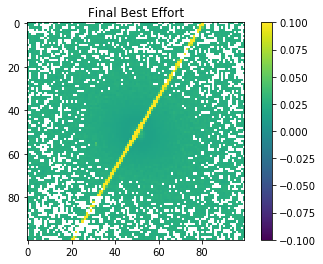

0.037154694773 0.0590402638703


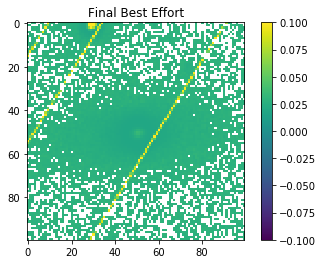

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:41: RuntimeWarning: invalid value encountered in sqrt


0.0204106615495 0.00113609292392


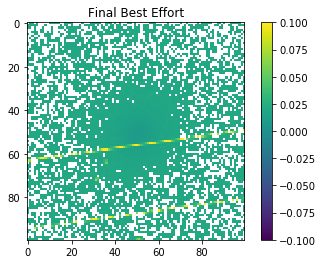

0.0227462581934 0.00111535938693


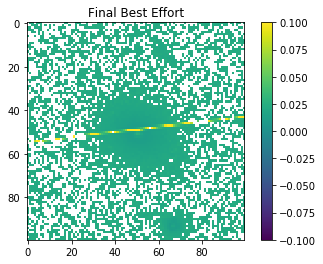

0.0202207352394 0.00112858475663


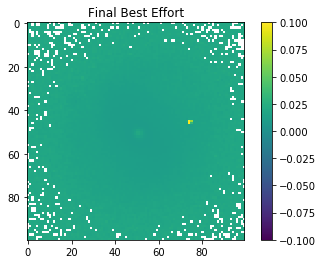

0.0139240164836 0.00179647015541


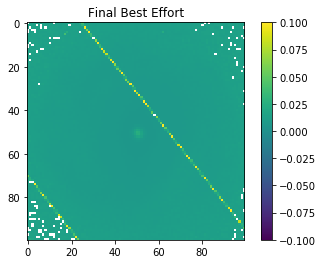

0.0217593989503 0.00114412159111


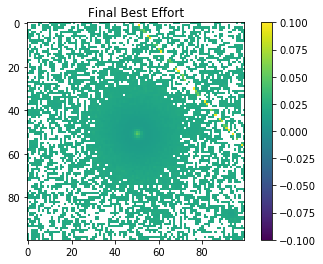

0.023630372897 0.0170944034262


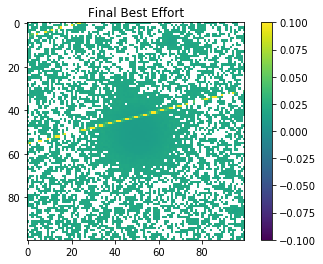

0.018794968786 0.00310087547022


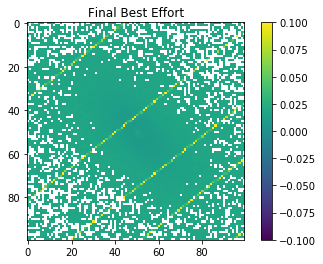

0.0201074230787 0.00121506880053


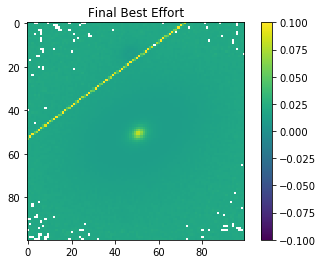

0.0213833470344 0.00125514765019


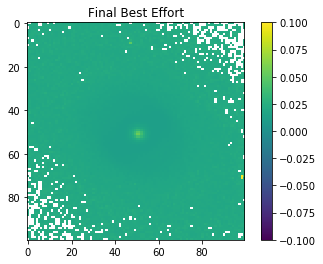

0.0201362646338 0.00111749359633


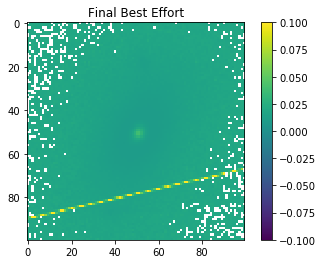

0.0113301886259 0.000401053808636


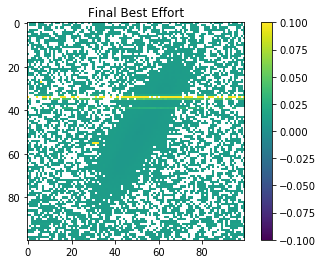

0.0122816016263 0.000783067496329


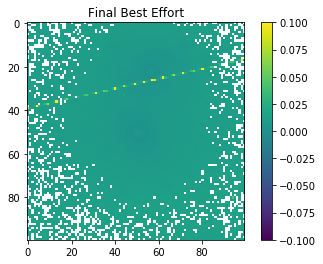

0.016276954824 0.000560175964321


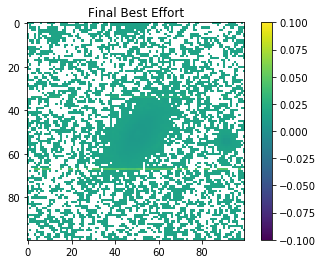

0.0157406717417 0.000501534760145


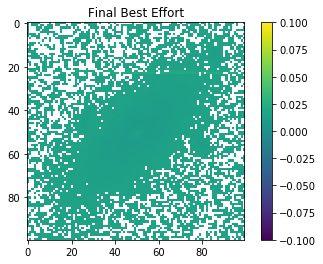

0.015159052378 0.000773803063436


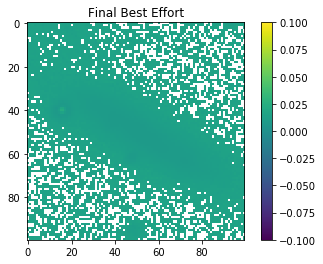

0.0208288017518 0.000766567983189


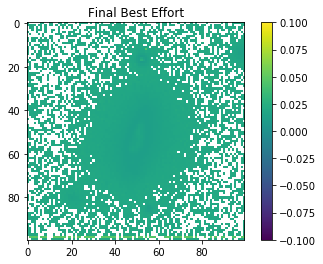

0.024500721491 0.00119840698726


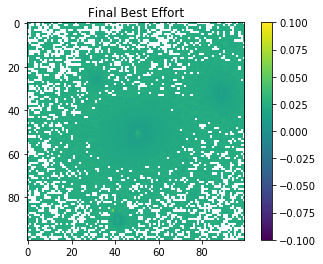

0.0180851990823 0.000905993764383


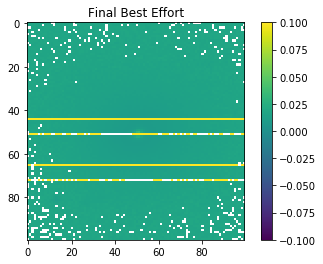

0.0187895096055 0.000973579903163


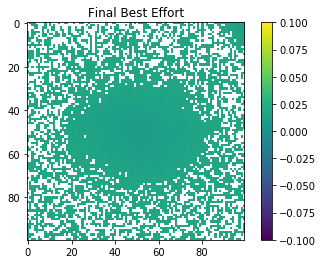

0.0191269920956 0.000691551746562


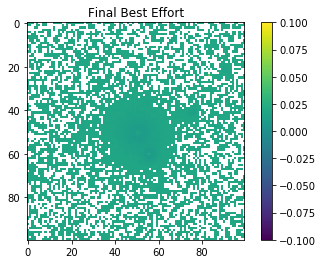

0.0204020374258 0.00119896264233


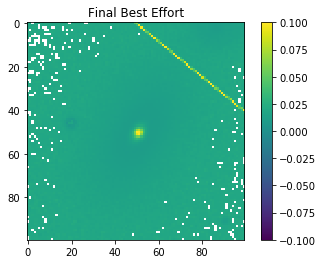

0.0257635758426 0.0012870221614


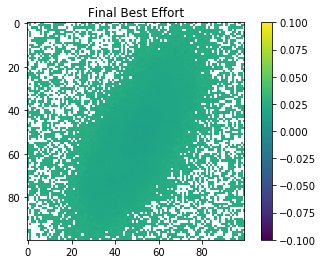

0.023327719528 0.00109897881707


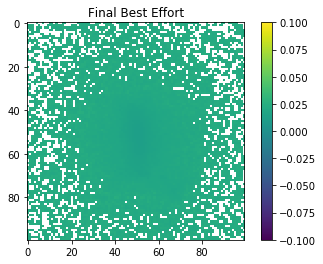

0.0202643832848 0.00118445168499


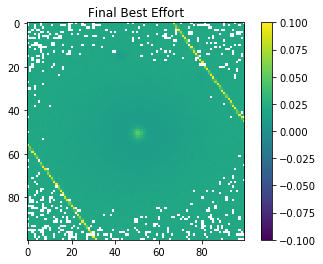

0.0221560429466 0.00117183098605


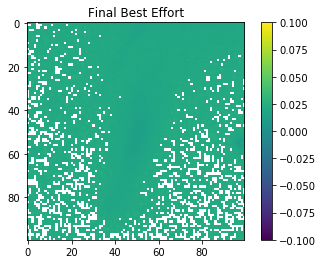

0.021027061657 0.00154459386839


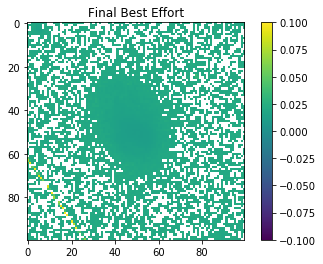

0.0126213648324 0.000733033481681


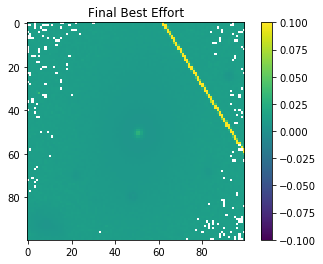

0.0150813322101 0.000600741208304


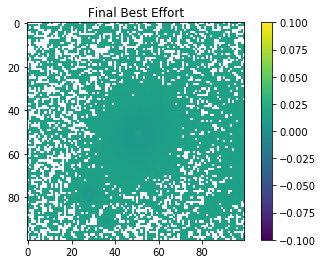

0.0134798353186 0.000954767276138


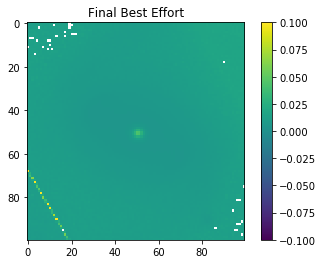

0.0171831630685 0.00107158689183


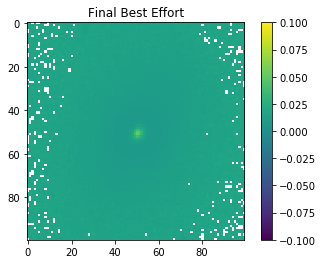

0.0170885037201 0.00224114667448


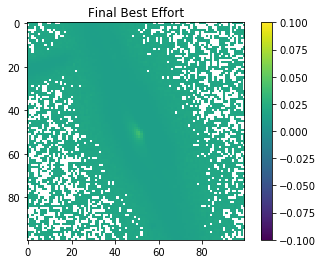

0.0166988096601 0.0339957992386


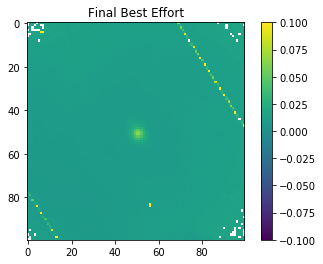

0.0128878176281 0.00106282575504


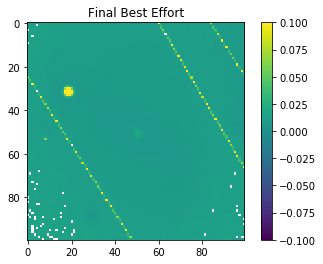

0.0180730451097 0.00332203810487


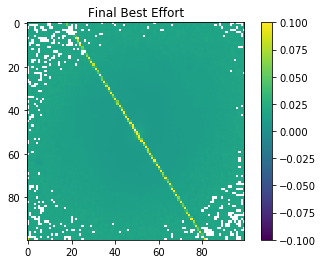

0.0177335897204 0.0010106493988


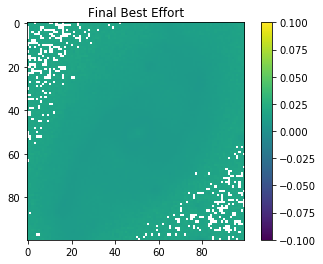

0.0257982690281 0.0475473768748


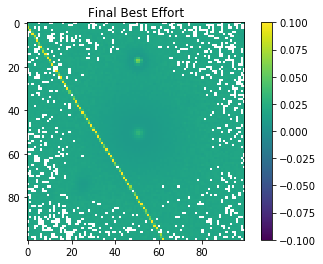

0.0228624905387 0.00120958539335


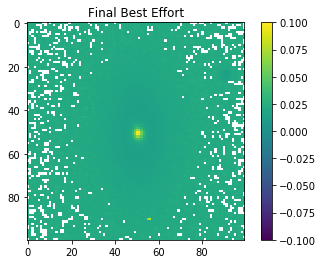

0.0171410546193 0.00133579625792


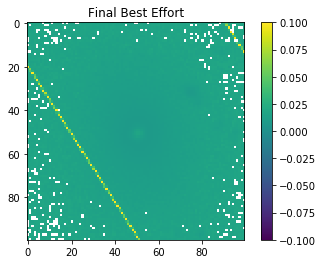

0.0173719658922 0.00148892982566


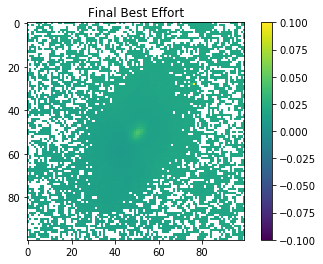

0.0153308636685 0.000656858956468


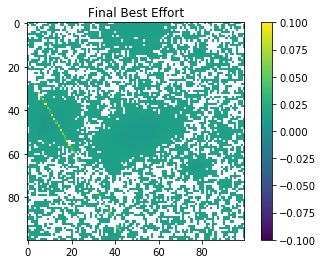

0.0180648646891 0.00107039720019


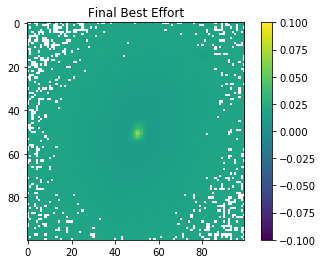

0.023925239142 0.0012781742487


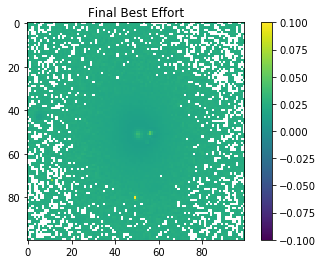

0.0257715767801 0.00107981351299


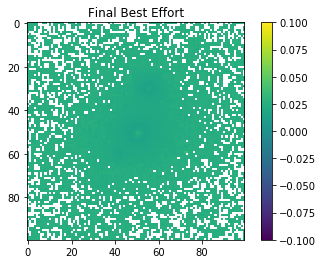

0.016842035822 0.000912698343473


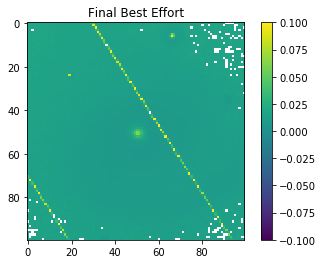

0.0156694173254 0.000698227166204


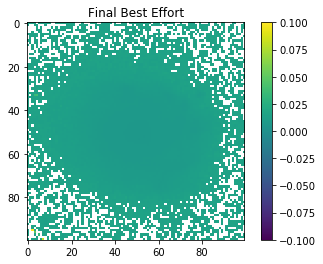

overall mean 0.0195559304415
overall std 0.00422252065263
how close were you? [0.022064180340780514, 0.023769022001463434, 0.01726320554242914, 0.037461127365299683, 0.032951677837518178, 0.022843098735647136, 0.025432140458246346, 0.017461302128888943, 0.012528592879827877, 0.02117579742641288, 0.020793658362526515, 0.021175745728043708, 0.018917888619324603, 0.020236055902423927, 0.019926869864561759, 0.016653366103036409, 0.01154213766952648, 0.016249442670631539, 0.015010075179047072, 0.014480235732404095, 0.019859733156393927, 0.023235157427459668, 0.051738031032406852, 0.017511100835532548, 0.018615879637329649, 0.019241765160435399, 0.023038063096738753, 0.021881434937594535, 0.021340800266639849, 0.021218788708482886, 0.021403478128341272, 0.014266102610977251, 0.014318165857341886, 0.011183876860997487, 0.014892533065062399, 0.016919742041139083, 0.012326028384167621, 0.012578364629982203, 0.016097311165923903, 0.013231520349220679, 0.018923503411754788, 0.02115285714637806, 0

In [199]:
plt.clf()
gains=[]
reads=[]
for i in range(len(filenames)):
    file='preimage/'+filenames[i]
    preimage=pyfits.open(file)
    print('skyval', preimage[4].header['SKYVAL'])
    print('gain', preimage[4].header['GAIN'])
    gains.append(preimage[4].header['GAIN'])
    reads.append(preimage[4].header['RNOISE'])
print('average gain', np.mean(gains))
print('average readnoise', np.mean(reads))

print(preimage[4].header)

means_all=[]
std_all=[]
final_resid=[]
resid_before=[]

import numpy.ma as ma

for i in range(len(filenames)):
    
    
    #the median sky brightness of the r band is 20.86 mag, so what is this in nanomaggies?
    file='preimage/'+filenames[i]
    preimage=pyfits.open(file)
    #print(preimage[4].header)
    img=preimage[4].data
    ivar=preimage[5].data
    psf=preimage[6].data
    
    img=ma.masked_less(img, 0)
    
    ivar=ma.masked_where(img < 0, ivar)
    
    
    
    poisson_error=np.sqrt((img+preimage[4].header['RNOISE']+preimage[4].header['SKYVAL'])/preimage[4].header['GAIN'])
    ivar_error=1/np.sqrt(ivar)
    
    '''plt.imshow(img)
    plt.title('r-band Image in nanomaggies')
    plt.colorbar()
    plt.show()'''
    
    '''plt.imshow(img/preimage[4].header['GAIN'])
    plt.title('r-band Image in Counts')
    plt.colorbar()
    plt.show()
    
    plt.imshow(poisson_error,vmin=0,vmax=0.07)
    plt.title('Poisson standard deviation')
    plt.colorbar()
    plt.show()'''
    
    sky_resids=np.random.normal(0.0,0.02,shape(img))
    #the native pixelscale is 0.396 so square that
    
    sky_resids_counts=np.random.normal(20**2,1,shape(img))
    
    '''fig=plt.figure()
    ax9=fig.add_subplot(2,3,1)
    ax9.set_title('Image in nmgy')
    im9=ax9.imshow(img, vmin=0, vmax=0.1)
    plt.colorbar(im9)
    
    ax0=fig.add_subplot(2,3,2)
    ax0.set_title('Image in Counts')
    im0=ax0.imshow(img/preimage[4].header['GAIN'])
    plt.colorbar(im0)
    
    
    ax1=fig.add_subplot(2,3,3)
    im1=ax1.imshow(ivar_error*preimage[4].header['GAIN'], vmin=0, vmax=120)
    ax1.set_title('Ivar error')
    plt.colorbar(im1)
    
    ax2=fig.add_subplot(2,3,4)
    im2=ax2.imshow(ivar_error*preimage[4].header['GAIN']-np.sqrt((img)*preimage[4].header['GAIN']), vmin=-20, vmax=20)
    ax2.set_title('Ivar - Poisson error')
    plt.colorbar(im2)
    
    
    ax3=fig.add_subplot(2,3,5)
    im3=ax3.imshow(ivar_error*preimage[4].header['GAIN']-np.sqrt((img+preimage[4].header['RNOISE'])*preimage[4].header['GAIN']), vmin=-20, vmax=20)
    ax3.set_title('Just readnoise')
    plt.colorbar(im3)
    
    ax4=fig.add_subplot(2,3,6)
    im4=ax4.imshow(ivar_error*preimage[4].header['GAIN']-np.sqrt(sky_resids_counts+(img+preimage[4].header['RNOISE'])*preimage[4].header['GAIN']), vmin=-20, vmax=20)
    ax4.set_title('Sky')
    plt.colorbar(im4)
    plt.tight_layout()
    plt.show()
    
    plt.imshow(ivar_error, vmin=0,vmax=0.07)
    plt.title('r-band standard deviation')
    plt.colorbar()
    plt.show()'''

    
    
    #print(len(img))
    #you need to mask everything that is less than zero
    poisson_error_new=np.sqrt((img+preimage[4].header['RNOISE'])/preimage[4].header['GAIN'])
    
    systematics=np.random.normal(0,0.02,shape(img))
    
    error_plus_systematics=np.sqrt((img+systematics*img+preimage[4].header['RNOISE'])/preimage[4].header['GAIN'])
    '''plt.hist(systematics)
    plt.title('Systematics')
    plt.show()
    
    fig=plt.figure()
    ax1=fig.add_subplot(1,1,1)
    im1=ax1.imshow(ivar_error,vmin=0,vmax=0.07)
    ax1.set_title('Ivar error')
    plt.colorbar(im1)
    plt.show()
 
   
    
    fig=plt.figure()
    ax1=fig.add_subplot(1,1,1)
    im1=ax1.imshow(poisson_error_new,vmin=0,vmax=0.07)
    ax1.set_title('Poisson standard deviation')
    plt.colorbar(im1)
    plt.show()
    
    fig=plt.figure()
    ax1=fig.add_subplot(1,1,1)
    im1=ax1.imshow(ivar_error-poisson_error_new, vmin=0, vmax=0.02)
    ax1.set_title('Real error - poisson')
    plt.colorbar(im1)
    plt.show()
    
    plt.hist(ivar_error-poisson_error_new, bins=10)
    plt.xlim([0,0.07])
    plt.show()'''
    
    resids=ivar_error-poisson_error_new
    
    '''plt.clf()
    fig=plt.figure()
    ax1=fig.add_subplot(1,2,1)
    im1=ax1.imshow(ivar_error-poisson_error_new, vmin=0, vmax=0.02)
    ax1.set_title('IVAR - Poisson')
    plt.colorbar(im1)
    
    
    ax2=fig.add_subplot(1,2,2)
    
    im2=ax2.imshow(resids[0:20,0:20],vmin=0, vmax=0.02)
    plt.colorbar(im2)
    ax2.set_title('Background Residuals')
    plt.tight_layout()
    savefig('../MaNGA_papers/Paper_I/background_estimation.pdf')'''
    
    print(np.mean(resids[0:20,0:20]), np.std(resids[0:20,0:20]))
    #print(np.median(resids[0:20,0:20]))
    
    resid_patch_1=resids[0:20,0:20]
    resid_patch_2=resids[80:100,80:100]
    resid_patch_3=resids[0:20,80:100]
    resid_patch_4=resids[80:100,0:20]
    

    means_all.append(np.mean(resids[0:20,0:20]))
    std_all.append(np.std(resids[0:20,0:20]))
    
    
    sky_resids_mine=np.random.normal(0.01955593,0.0042225,shape(img))
    poisson_plus = np.sqrt((img+ 0.004701377)/1367.29546)+sky_resids_mine
    
    final_resid.append(np.mean(ivar_error-poisson_plus))
    resid_before.append(np.mean(ivar_error-poisson_error_new))
    
    plt.imshow(ivar_error-poisson_error_new, vmin=-0.1, vmax=0.1)
    plt.title('Final Best Effort')
    plt.colorbar()
    plt.show()
    #print(preimage[4].header['RNOISE'])
print('overall mean',np.mean(means_all)) 
print('overall std', np.mean(std_all))
print('how close were you?', resid_before, np.mean(resid_before))
print('how close are you?', final_resid, np.mean(final_resid))

In [201]:
fig=plt.figure()
ax = fig.add_subplot(1,1,1) 
ax0=fig.add_subplot(1,2,1)
ax0.hist(resid_before,bins=10, histtype='stepfilled')
ax0.axvline(x=np.mean(resid_before), color='black')
ax0.set_title(r'$\sigma_{ivar}-\sigma_{Poisson}$')
ax0.set_xlim([-0.03,0.03])
ax0.annotate(r'$\mu$ = '+str(round(np.mean(resid_before),4)), xy=(0.05,0.95), xycoords='axes fraction')
ax0.annotate(r'$\sigma$ = '+str(round(np.std(resid_before),4)), xy=(0.05,0.9), xycoords='axes fraction')
 
    

ax1=fig.add_subplot(1,2,2)
ax1.hist(final_resid, bins=10, color='orange', histtype='stepfilled')
ax1.axvline(x=np.mean(final_resid), color='black')
ax1.set_title(r'$\sigma_{ivar}-\sigma_{Poisson+skyval}$')
ax1.set_xlim([-0.03,0.03])

ax1.annotate(r'$\mu$ = '+str(round(np.mean(final_resid),4)), xy=(0.05,0.95), xycoords='axes fraction')
ax1.annotate(r'$\sigma$ = '+str(round(np.std(final_resid),4)), xy=(0.05,0.9), xycoords='axes fraction')
 


# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top='off', bottom='off', left='off', right='off')

ax.set_xlabel(r'Residual Counts')
savefig('../MaNGA_papers/Paper_I/histograms_background.pdf')

In [13]:
'''NOW try to read into the header of the ivar file to see if there are additional terms that
become important towards the outskirts of the galaxy'''


print(preimage[4].header)

XTENSION= 'IMAGE   '           / Image extension                                BITPIX  =                  -64 / array data type                                NAXIS   =                    2 / number of array dimensions                     NAXIS1  =                  100                                                  NAXIS2  =                  100                                                  PCOUNT  =                    0 / number of parameters                           GCOUNT  =                    1 / number of groups                               DATE    = '2013-12-07'         / Creation UTC (CCCC-MM-DD) date of FITS header  COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    COMMENT Sloan Digital Sky Survey (SDSS) data                                    COMMENT assembled with code from photoop and idlutils                           CTYPE1  = 'RA---TAN'           / Coordin

In [204]:
print('~~~~~~Background Stats~~~~~~~')
print('overall mean',np.mean(means_all), np.std(means_all)) 
print('overall std', np.mean(std_all), np.std(std_all))


print('~~~~~~Image Stats~~~~~~~')
print('gain', np.mean(gains), np.std(gains))
print('readnoise', np.mean(reads), np.std(reads))

print('~~~~~~Testing Gains~~~~~~~')
print(len(gains))


~~~~~~Background Stats~~~~~~~
overall mean 0.0195559304415 0.00458937863338
overall std 0.00422252065263 0.0112948853025
~~~~~~Image Stats~~~~~~~
gain 1367.29546 686.545400708
readnoise 0.004701377 0.000869319325588
~~~~~~Testing Gains~~~~~~~
50


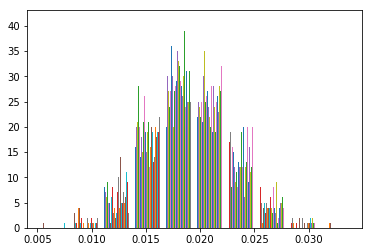

/Users/beckynevin/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in sqrt


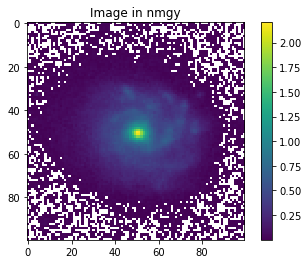

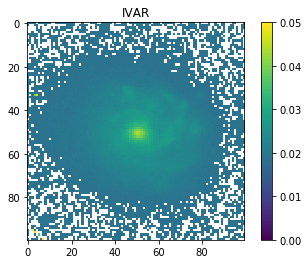

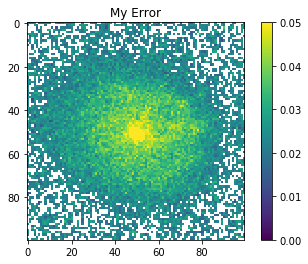

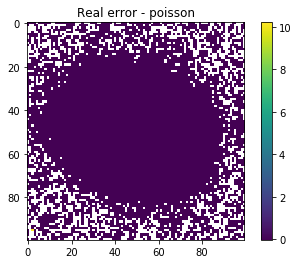

In [187]:
'''Check this technique for subtracting off error from 
your existing images'''

poisson_error_new=np.sqrt(abs(img+preimage[4].header['RNOISE'])/np.mean(gains))
#ivar - this is in units of counts so add back in the residual counts
plt.clf()

sky_resids_mine=np.random.normal(np.mean(means_all),np.mean(std_all),shape(img))
plt.hist(sky_resids_mine)
plt.show()



poisson_plus = np.sqrt((img+np.mean(reads))/np.mean(gains))+sky_resids_mine

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
im1=ax1.imshow(img)
ax1.set_title('Image in nmgy')
plt.colorbar(im1)
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
im1=ax1.imshow(ivar_error, vmin=0, vmax=0.05)
ax1.set_title('IVAR')
plt.colorbar(im1)
plt.show()

fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
im1=ax1.imshow(poisson_plus, vmin=0, vmax=0.05)
ax1.set_title('My Error')
plt.colorbar(im1)
plt.show()

subbed=ivar_error-poisson_plus


fig=plt.figure()
ax1=fig.add_subplot(1,1,1)
im1=ax1.imshow(subbed)
ax1.set_title('Real error - poisson')
plt.colorbar(im1)
plt.show()



In [202]:
'''I also need to go through and determine what the PSF is'''
import scipy.optimize as opt
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

psf_std=[]
for i in range(len(filenames)):
    file='preimage/'+filenames[i]
    preimage=pyfits.open(file)

    psf=preimage[6].data
    psf_flattened=psf.ravel()
    #print(preimage[4].header)
    '''plt.imshow(psf)
    plt.colorbar()
    plt.show()'''
    
    x = np.linspace(0, shape(psf)[0]-1, shape(psf)[0])
    y = np.linspace(0, shape(psf)[1]-1, shape(psf)[1])
    x, y = np.meshgrid(x, y)
    initial_guess = (max(psf_flattened),30,30,3,3,0,10)

    popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), psf_flattened, p0=initial_guess)
    #And plot the results:
    #print(popt)
    data_fitted = twoD_Gaussian((x, y), *popt)

    fig, ax = plt.subplots(1, 1)
    '''ax.hold(True)
    ax.imshow(psf.reshape(61, 61), cmap=plt.cm.jet, origin='bottom',
        extent=(x.min(), x.max(), y.min(), y.max()))
    ax.contour(x, y, data_fitted.reshape(61, 61), 3, colors='w')
    ax.set_xlim([20,40])
    ax.set_ylim([20,40])
    ax.annotate(r'$\sigma$ ='+str(np.sqrt(popt[3]**2+popt[4]**2)), xy=(0.1,0.1), xycoords='axes fraction', color='white')
    plt.show()'''
    psf_std.append(np.sqrt(popt[3]**2+popt[4]**2))
print('FWHM in "',2.355*0.396*np.mean(psf_std))
    
    

/Users/beckynevin/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


FWHM in " 1.72850404008


'''I also need to go through and determine what the PSF is'''
import scipy.optimize as opt
def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    (x, y) = xdata_tuple
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
#You'll obviously need to reshape the output for plotting, e.g:

# Create x and y indices
x = np.linspace(0, 200, 201)
y = np.linspace(0, 200, 201)
x, y = np.meshgrid(x, y)

#create data
data = twoD_Gaussian((x, y), 3, 100, 100, 20, 40, 0, 10)

# plot twoD_Gaussian data generated above
plt.figure()
plt.imshow(data.reshape(201, 201))
plt.colorbar()
#Do the fitting as before:

# add some noise to the data and try to fit the data generated beforehand
initial_guess = (3,100,100,20,40,0,10)

data_noisy = data + 0.2*np.random.normal(size=data.shape)

popt, pcov = opt.curve_fit(twoD_Gaussian, (x, y), data_noisy, p0=initial_guess)
#And plot the results:

data_fitted = twoD_Gaussian((x, y), *popt)

fig, ax = plt.subplots(1, 1)
ax.hold(True)
ax.imshow(data_noisy.reshape(201, 201), cmap=plt.cm.jet, origin='bottom',
    extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(x, y, data_fitted.reshape(201, 201), 8, colors='w')
plt.show()

SIMPLE  =                    T /                                                BITPIX  =                  -32 / 32 bit floating point                          NAXIS   =                    2                                                  NAXIS1  =                 2048                                                  NAXIS2  =                 1489                                                  EXTEND  =                    T /Extensions may be present                       BZERO   =              0.00000 /Set by MRD_SCALE                                BSCALE  =              1.00000 /Set by MRD_SCALE                                TAI     =        4527650181.67 / 1st row - Number of seconds since Nov 17 1858  RA      =            226.16041 / 1st row - Right ascension of telescope boresighDEC     =            49.762472 / 1st row - Declination of telescope boresight (dSPA     =             123.717  / 1st row - Camera col position angle wrt north (IPA     =             359.155  / 1st row

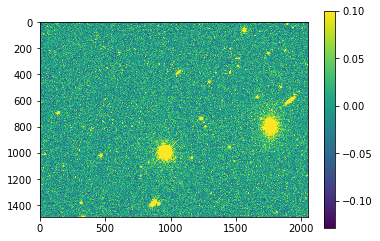

0.00497187 nanomaggies per count


In [39]:
'''From dr8 im pulling an image'''
file='../../Downloads/frame-r-003187-1-0013.fits'
r_image=pyfits.open(file)
print(r_image[0].header)
plt.imshow(r_image[0].data, vmax=0.1)
plt.colorbar()
plt.show()

print(r_image[0].header['NMGY'], 'nanomaggies per count')

In [26]:
1/0.005

200.0

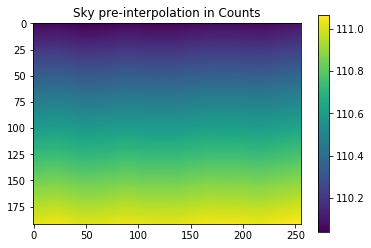

xnew inputs 0 1489 0 2048
(192, 256) (192, 256) (192, 256)
xold inputs 0 192 0 256
192 192 192
SIMPLE  =                    T /                                                BITPIX  =                  -32 / 32 bit floating point                          NAXIS   =                    2                                                  NAXIS1  =                 2048                                                  NAXIS2  =                 1489                                                  EXTEND  =                    T /Extensions may be present                       BZERO   =              0.00000 /Set by MRD_SCALE                                BSCALE  =              1.00000 /Set by MRD_SCALE                                TAI     =        4527650181.67 / 1st row - Number of seconds since Nov 17 1858  RA      =            226.16041 / 1st row - Right ascension of telescope boresighDEC     =            49.762472 / 1st row - Declination of telescope boresight (dSPA     =             123

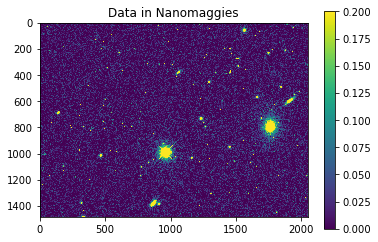

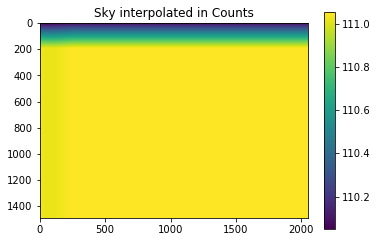

In [48]:
im=pyfits.open('../../Downloads/frame-r-003187-1-0013.fits')


sky=im[2].data
sky_header=im[2].header


calib=im[1].data


plt.imshow(sky[0][0])
plt.title('Sky pre-interpolation in Counts')
plt.colorbar()
plt.show()

#>>> xnew, ynew = np.mgrid[-1:1:70j, -1:1:70j]
#>>> tck = interpolate.bisplrep(x, y, z, s=0)
#>>> znew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)




xnew, ynew = np.mgrid[0:shape(im[0].data)[0] , 0:shape(im[0].data)[1] ]

print('xnew inputs',0, shape(im[0].data)[0], 0 , shape(im[0].data)[1])

xold, yold = np.mgrid[0:(shape(sky[0][0])[0]) , 0:(shape(sky[0][0])[1]) ]

print(shape(xold), shape(yold), shape(sky[0][0]))

print('xold inputs', 0 , (shape(sky[0][0])[0]) , 0 , (shape(sky[0][0])[1]) )

print(len(xold),len(yold),len(sky[0][0]))


tck = interpolate.bisplrep(xold,yold, sky[0][0])
snew = interpolate.bisplev(xnew[:,0], ynew[0,:], tck)

#simg= interpolate(sky.allsky, sky['XINTERP'], sky['YINTERP'])



print(im[0].header)
plt.imshow(im[0].data, vmin=0, vmax=.2)
plt.title('Data in Nanomaggies')
plt.colorbar()
plt.show()

plt.imshow(snew)
plt.title('Sky interpolated in Counts')
plt.colorbar()
plt.show()